In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'
polbeamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles_polar/'

In [2]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_slice_xy(xes,yes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col


def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat



In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

find = 900

cmm = cm.magma
fsz=16

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY618_Corrected_amplitudes.pkl' 'FLY619_Corrected_amplitudes.pkl'
 'FLY620_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625

625 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY625_20211021T214028Z_ver_20231114T175419_concat_bgonly.pkl'>
[ 4.17140671e-08 -1.45807029e+00  1.00157997e+01  1.16252174e+00
  9.34712163e+00  4.35349501e-10  0.00000000e+00]


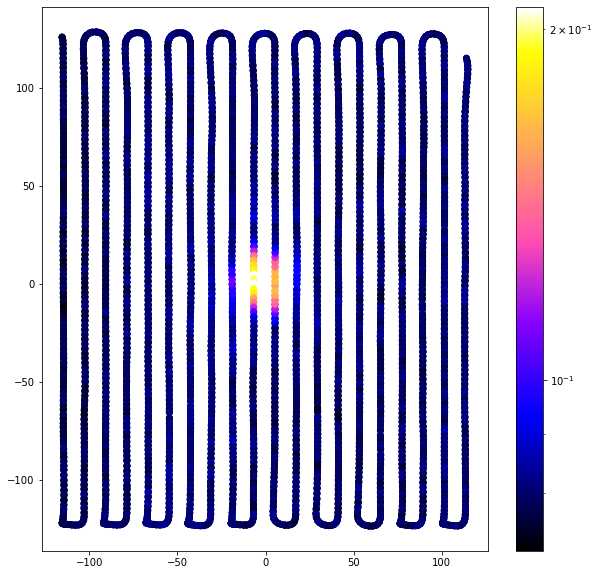

<ipython-input-34-d2ee765c322f>:41: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(x,y,c=z,cmap=cm.gnuplot2,vmin=1,vmax=1E-4,norm=LogNorm())


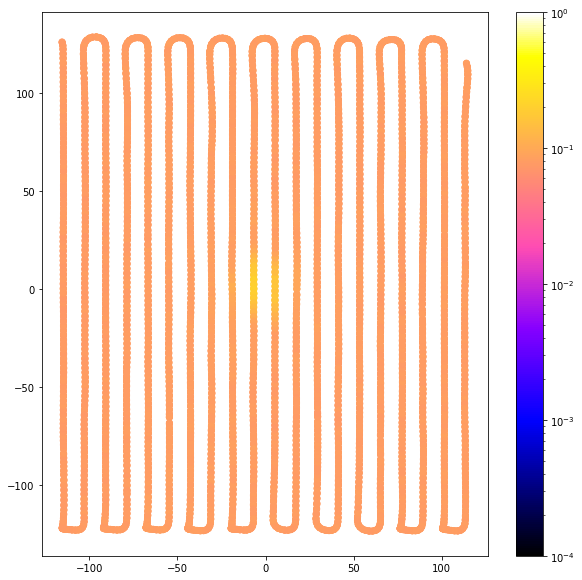

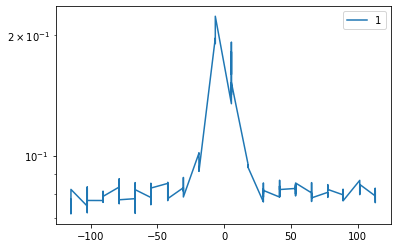

In [34]:
# This checks the background level without any processing beyond the pickle file

# Read in Flight 618
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
t_cut_618=concattest618.inds_on
t_cut_618_off = concattest618.inds_off


## Let's start by checking regular co-pol normalization - N pol: 

chind=pols[0]
print(concattest618.G_popt[chind,find,:])

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bg[t_cut_618,find,chind]/concattest618.G_popt[chind,find,0]
z_off = concattest618.V_bg[t_cut_618_off,find,chind]

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()


x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bg[t_cut_618,find,chind]/concattest618.G_popt[chind,find,0]
z_off = concattest618.V_bg[t_cut_618_off,find,chind]/concattest618.G_popt[chind,find,0]

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,vmin=1,vmax=1E-4,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it

chind = pols[0]
z_off = concattest618.V_bg[t_cut_618_off,find,chind]/concattest618.G_popt[chind,find,0]
ixd = get_slice_xy(x,y,0.0,ax='y') # grabbed x slice
plt.semilogy(x[ixd],z_off[ixd],label=str(chind))
plt.legend()
plt.show()


In [43]:
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
GNORM = concattest618.G_popt[chind,find,0]

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY618_20211021T183430Z_ver_20231114T161857_concat_bgonly.pkl'>


618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY618_20211021T183430Z_ver_20231114T161857_concat_bgonly.pkl'>
[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]
619 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY619_20211021T185805Z_ver_20231114T164442_concat_bgonly.pkl'>
[ 4.16061888e-08 -3.16224407e+00  9.96166469e+00  1.55127342e+00
  9.33063305e+00  4.61490547e-10  0.00000000e+00]
625 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY625_20211021T214028Z_ver_20231114T175419_concat_bgonly.pkl'>
[ 4.17140671e-08 -1.45807029e+00  1.00157997e+01  1.16252174e+00
  9.34712163e+00  4.35349501e-10  0.00000000e+00]
646 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 40
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/f

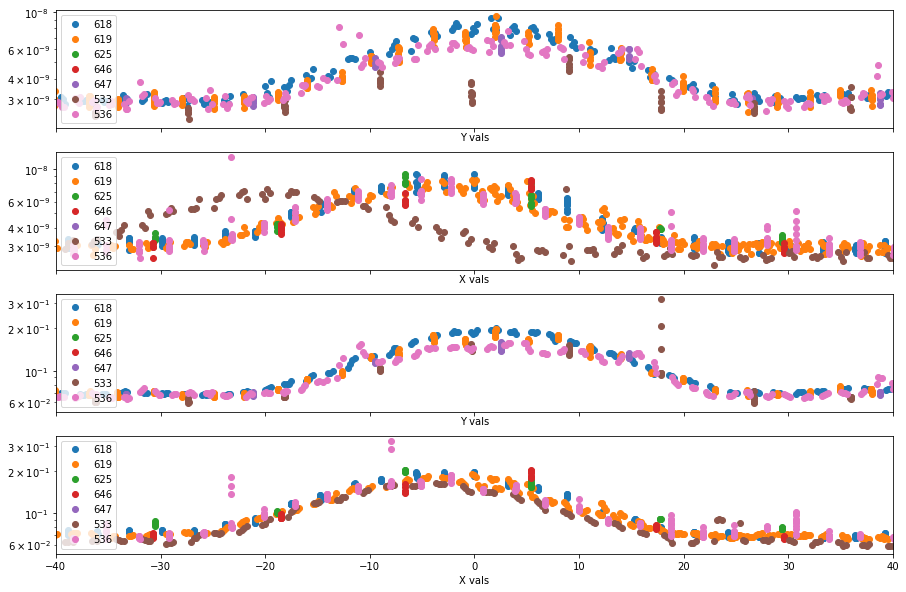

In [44]:
fig,axs = plt.subplots(4, 1, sharex=True,figsize=(15,10),squeeze=True)

for fly in Npolflights:

    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest618=pickle.load(pfile)
    t_cut_618=concattest618.inds_on
    t_cut_618_off = concattest618.inds_off


    ## Let's start by checking regular co-pol normalization - N pol: 

    chind=pols[0]
    print(concattest618.G_popt[chind,find,:])

    x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    z = concattest618.V_bg[t_cut_618,find,chind]/GNORM
    z_off = concattest618.V_bg[t_cut_618_off,find,chind]

    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    axs[0].semilogy(y[ixd],z_off[ixd],marker='o',linestyle='None',label=fly)
    ixd = get_slice_xy(x,y,0.0,ax='y') # grabbed x slice
    axs[1].semilogy(x[ixd],z_off[ixd],marker='o',linestyle='None',label=fly)
    
    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    axs[2].semilogy(y[ixd],z[ixd],marker='o',linestyle='None',label=fly)
    ixd = get_slice_xy(x,y,0.0,ax='y') # grabbed x slice
    axs[3].semilogy(x[ixd],z[ixd],marker='o',linestyle='None',label=fly)
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('Y vals')
axs[1].set_xlabel('X vals')
axs[2].legend()
axs[3].legend()
axs[2].set_xlabel('Y vals')
axs[3].set_xlabel('X vals')
axs[0].set_xlim(-40,40)
plt.show()


In [ ]:
# beammap this flight, with gaussnorm, and see what happens



533 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 36
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY533_20210826T182904Z_ver_20231114T150159_concat_bgonly.pkl'>
[ 1.50106865e-07 -4.62267260e+00  1.29233236e+01  2.09601574e+00
  1.18373405e+01  1.79480725e-09  0.00000000e+00]


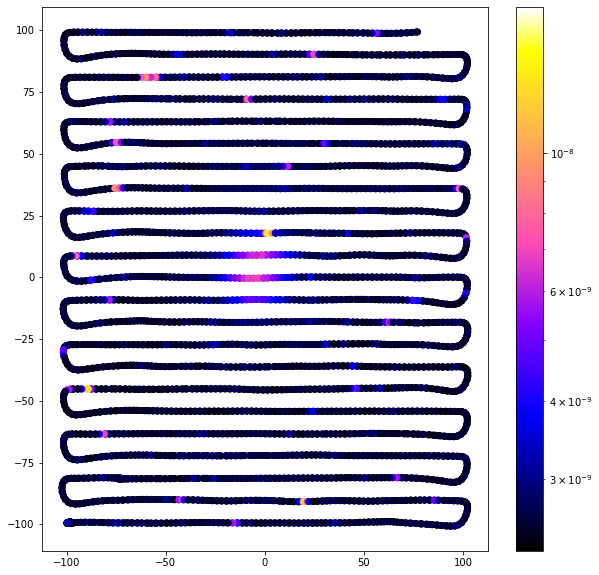

<ipython-input-11-a9ab8b9e8cb6>:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(x,y,c=z,cmap=cm.gnuplot2,vmin=1,vmax=1E-4,norm=LogNorm())


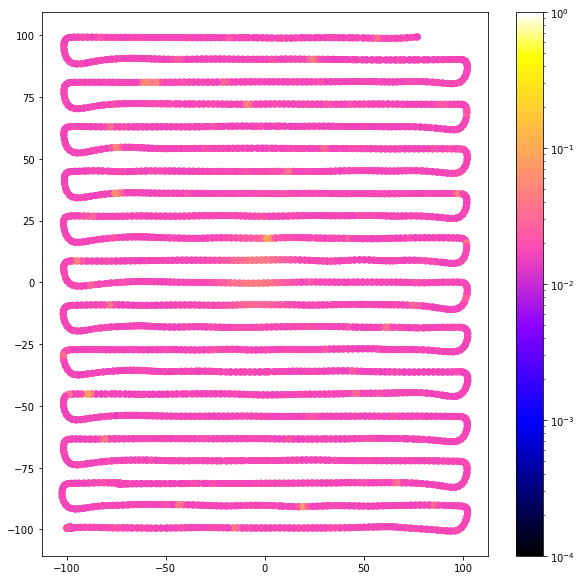

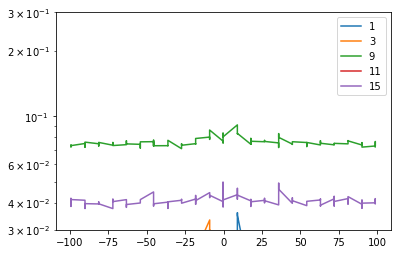

In [11]:
# Read in Flight 618
fly = '533'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
t_cut_618=concattest618.inds_on
t_cut_618_off = concattest618.inds_off


## Let's start by checking regular co-pol normalization - N pol: 

chind=pols[0]
print(concattest618.G_popt[chind,find,:])

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bg[t_cut_618,find,chind]
z_off = concattest618.V_bg[t_cut_618_off,find,chind]

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()


x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bg[t_cut_618,find,chind]/concattest618.G_popt[chind,find,0]
z_off = concattest618.V_bg[t_cut_618_off,find,chind]/concattest618.G_popt[chind,find,0]

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,vmin=1,vmax=1E-4,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it

for chind in pols:
    z_off = concattest618.V_bg[t_cut_618_off,find,chind]/concattest618.G_popt[chind,find,0]
    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    plt.semilogy(y[ixd],z_off[ixd],label=str(chind))
plt.legend()
plt.ylim(3E-2,3E-1)
plt.show()


In [21]:
# Now let's examine the different contributions in the background from the main beam section 
# and the outside


find = 900
colorz = pu.cm_to_discrete(cm.magma, 5)

# start with N pols
copoldir = 'N'
pols = N_pols

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar_bgonly.pkl'
with open(bpicklefile, 'rb') as inp:
    Ncobeam = pickle.load(inp)


# E pols
copoldir = 'E'
pols = E_pols

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar_bgonly.pkl'
with open(bpicklefile, 'rb') as inp:
    Ecobeam = pickle.load(inp)
    

    
col1,col2 = get_polar_slice(Ncobeam.d0_centers_grid[:,:,chind],
                          Ncobeam.d1_centers_grid[:,:,chind],0.0)

In [23]:
Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']


delt_the = np.radians(6)
delt_phi = np.radians(1)

flights = ['646','647','533']
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]
N_inner=ba.Beammap_polar(concatlist=concytest,
                coordsys='polar',
                d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                d1args=[0,np.radians(36),delt_phi],
                normalization='Gauss_wcorr',operation='coadd',Fargs=[find,find+1,1],
                f_index=find,vplot=False,mask=True)

flights = ['618','619','625','536']
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]
N_outer=ba.Beammap_polar(concatlist=concytest,
                coordsys='polar',
                d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                d1args=[0,np.radians(36),delt_phi],
                normalization='Gauss_wcorr',operation='coadd',Fargs=[find,find+1,1],
                f_index=find,vplot=False,mask=True)


flights = ['535','648','649']
concytest=[glob.glob(pckldir+'*'+fly+'_2*')[0] for fly in flights]
E_inner=ba.Beammap_polar(concatlist=concytest,
                coordsys='polar',
                d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                d1args=[0,np.radians(36),delt_phi],
                normalization='Gauss_wcorr',operation='coadd',Fargs=[find,find+1,1],
                f_index=find,vplot=False,mask=True)


flights = ['620']
concytest=[glob.glob(pckldir+'FLY'+fly+'*')[0] for fly in flights]
E_outer=ba.Beammap_polar(concatlist=concytest,
                coordsys='polar',
                d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                d1args=[0,np.radians(36),delt_phi],
                normalization='Gauss_wcorr',operation='coadd',Fargs=[find,find+1,1],
                f_index=find,vplot=False,mask=True)

/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY646_20211022T183659Z_ver_20231114T181509_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY647_20211022T185749Z_ver_20231114T183630_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY533_20210826T182904Z_ver_20231114T150159_concat_bgonly.pkl
start of big ass loop is: 2023-12-05 15:26:54.225970
646 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz
647 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz
533 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-05 15:27:14.149656          
end of concat loop is: 2023-12-05 15:27:14.154296


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:483: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY618_20211021T183430Z_ver_20231114T161857_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY619_20211021T185805Z_ver_20231114T164442_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY625_20211021T214028Z_ver_20231114T175419_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY536_20210826T195003Z_ver_20231114T155706_concat_bgonly.pkl
start of big ass loop is: 2023-12-05 15:27:30.851231
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
625 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz
536 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-05 15:27:51.339832          
end of concat loop is: 2023-12-05 15:27:51.

/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY620_20211021T192212Z_ver_20231114T170718_concat_bgonly.pkl
start of big ass loop is: 2023-12-05 15:39:23.439815
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-05 15:39:27.638274          
end of concat loop is: 2023-12-05 15:39:27.639641


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:483: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY535_20210826T192056Z_ver_20231114T153159_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY648_20211022T191922Z_ver_20231114T185620_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY649_20211022T194308Z_ver_20231114T191650_concat_bgonly.pkl
start of big ass loop is: 2023-12-05 15:34:20.454981
535 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz
648 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
649 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-05 15:34:36.176582          
end of concat loop is: 2023-12-05 15:34:36.181787
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY620_20211021T192212Z_ver_20231114T170718_concat_bgonly.pkl
start of big ass loop is: 2023-12-05 15:34:39.057610
620 /hirax/GBO_Analysis_Outputs/main_be

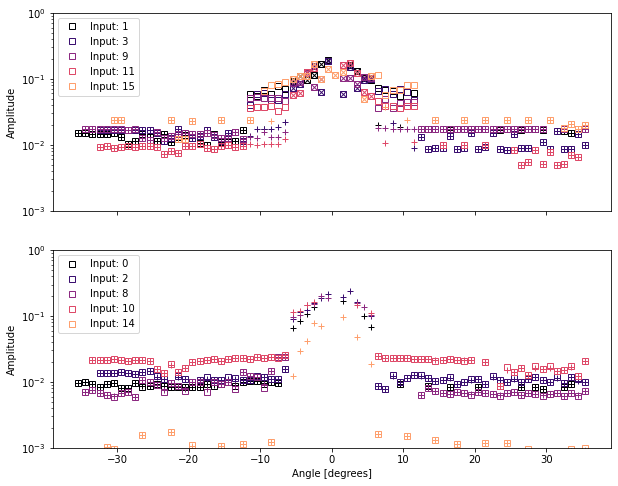

In [31]:

fig,axs = plt.subplots(2, 1, sharex=True,sharey=True,figsize=(10,8)) 
for i,chind in enumerate(N_pols):
    axs[0].semilogy(np.degrees(Ncobeam.d1_centers_grid[col1,:,chind]),Ncobeam.V_LC_operation[col1,:,0,chind],'s',
             color=colorz[i],mfc='none')
    axs[0].semilogy(-1.0*np.degrees(Ncobeam.d1_centers_grid[col2,:,chind]),Ncobeam.V_LC_operation[col2,:,0,chind],'s',
             color=colorz[i],mfc='none',label='Input: '+str(chind))
    axs[0].semilogy(np.degrees(N_inner.d1_centers_grid[col1,:,chind]),N_inner.V_LC_operation[col1,:,0,chind],'+',
             color=colorz[i])
    axs[0].semilogy(-1.0*np.degrees(N_inner.d1_centers_grid[col2,:,chind]),N_inner.V_LC_operation[col2,:,0,chind],'+',
             color=colorz[i])
    axs[0].semilogy(np.degrees(N_outer.d1_centers_grid[col1,:,chind]),N_outer.V_LC_operation[col1,:,0,chind],'x',
             color=colorz[i])
    axs[0].semilogy(-1.0*np.degrees(N_outer.d1_centers_grid[col2,:,chind]),N_outer.V_LC_operation[col2,:,0,chind],'x',
             color=colorz[i])
    
for i,chind in enumerate(E_pols):
    axs[1].semilogy(np.degrees(Ecobeam.d1_centers_grid[col1,:,chind]),Ecobeam.V_LC_operation[col1,:,0,chind],'s',
             color=colorz[i],mfc='none')
    axs[1].semilogy(-1.0*np.degrees(Ecobeam.d1_centers_grid[col2,:,chind]),Ecobeam.V_LC_operation[col2,:,0,chind],'s',
             color=colorz[i],mfc='none',label='Input: '+str(chind))
    axs[1].semilogy(np.degrees(E_inner.d1_centers_grid[col1,:,chind]),E_inner.V_LC_operation[col1,:,0,chind],'+',
             color=colorz[i])
    axs[1].semilogy(-1.0*np.degrees(E_inner.d1_centers_grid[col2,:,chind]),E_inner.V_LC_operation[col2,:,0,chind],'+',
             color=colorz[i])
    axs[1].semilogy(np.degrees(E_outer.d1_centers_grid[col1,:,chind]),E_outer.V_LC_operation[col1,:,0,chind],'+',
             color=colorz[i])
    axs[1].semilogy(-1.0*np.degrees(E_outer.d1_centers_grid[col2,:,chind]),E_outer.V_LC_operation[col2,:,0,chind],'+',
             color=colorz[i])
    
axs[1].set_xlabel('Angle [degrees]')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Amplitude')
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[0].set_ylim(1E-3,1)
plt.show()

In [7]:




Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

flights = Epolflights

delt_the = np.radians(6)
delt_phi = np.radians(1)

for find in good_freqs[115:116]:
    print('Working on Frequency: ',find,freqs[find])

    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]
    beamtest=ba.Beammap_polar(concatlist=concytest,
                coordsys='polar',
                d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                d1args=[0,np.radians(36),delt_phi],
                normalization='Gauss_wcorr',operation='coadd',Fargs=[find,find+1,1],
                f_index=find,vplot=False,mask=True)
    

Working on Frequency:  900 448.4375
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY648_20211022T191922Z_ver_20231114T185620_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY648_20211022T191922Z_ver_20231114T185620_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY649_20211022T194308Z_ver_20231114T191650_concat_bgonly.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY535_20210826T192056Z_ver_20231114T153159_concat_bgonly.pkl
start of big ass loop is: 2023-12-04 17:31:12.521693
648 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
648 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
649 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz
535 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-12-04 17:31:33.246248          
end of 

/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:483: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


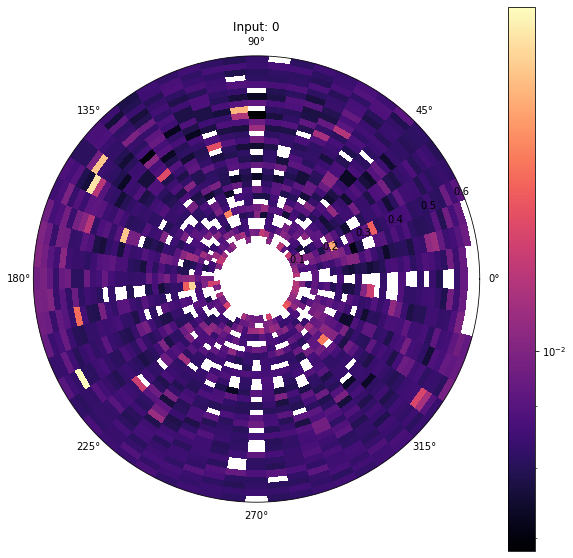

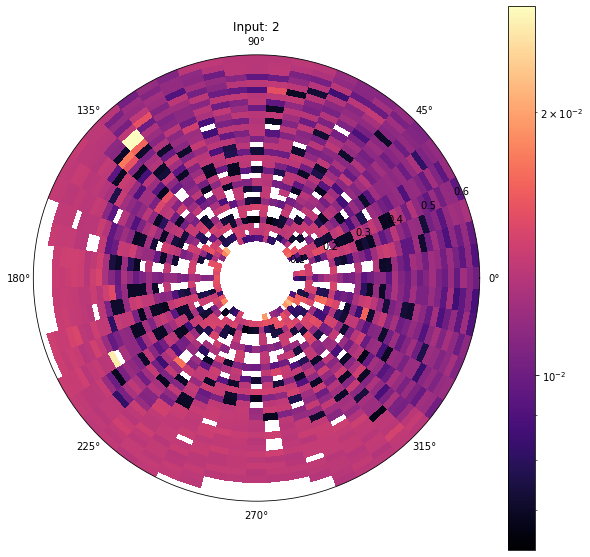

In [8]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar_bgonly.pkl'
with open(bpicklefile, 'rb') as inp:
    bptest = pickle.load(inp)
    


for i,chind in enumerate(pols[0:2]):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.pcolormesh(beamtest.d0_edges_grid[:,:,chind],beamtest.d1_edges_grid[:,:,chind],
                   beamtest.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

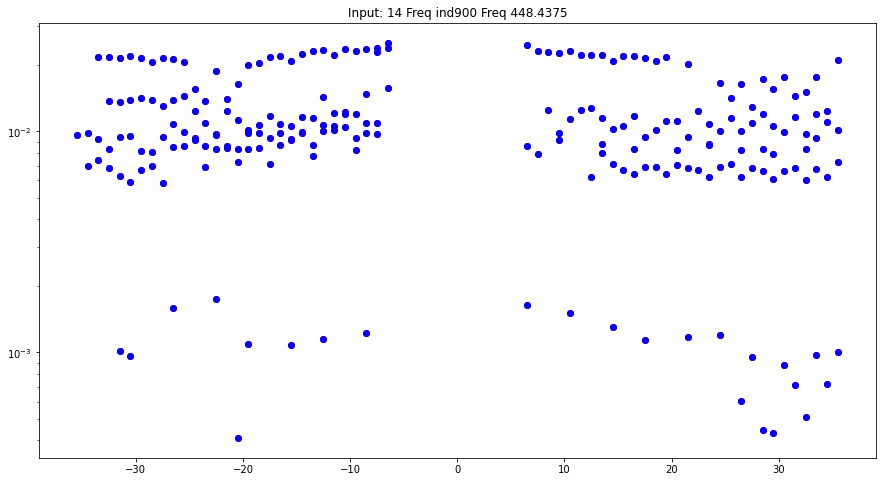

In [9]:
col1,col2 = get_polar_slice(beamtest.d0_centers_grid[:,:,chind],
                          beamtest.d1_centers_grid[:,:,chind],0.0)

fig = plt.figure(figsize=(15,8)) 
for chind in pols:
    plt.semilogy(np.degrees(beamtest.d1_centers_grid[col1,:,chind]),beamtest.V_LC_operation[col1,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(beamtest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*np.degrees(beamtest.d1_centers_grid[col2,:,chind]),beamtest.V_LC_operation[col2,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(beamtest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.semilogy(np.degrees(bptest.d1_centers_grid[col1,:,chind]),bptest.V_LC_operation[col1,:,0,chind],'o',
             color='blue',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*np.degrees(bptest.d1_centers_grid[col2,:,chind]),bptest.V_LC_operation[col2,:,0,chind],'o',
             color='blue',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.title('Input: '+str(chind)+ ' Freq ind'+str(find)+' Freq '+str(freqs[find]))
plt.show()

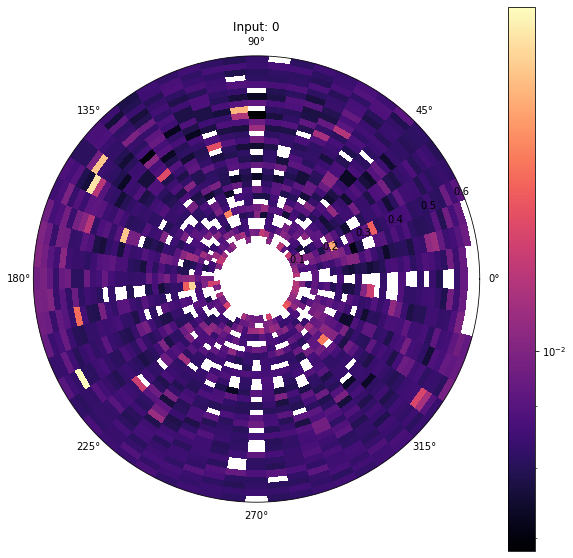

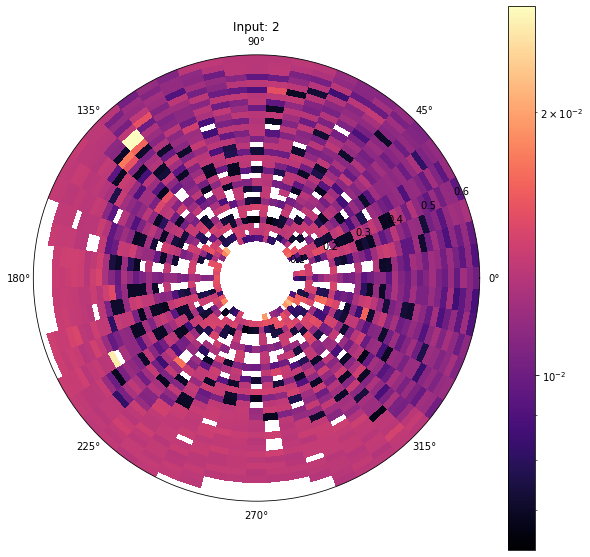

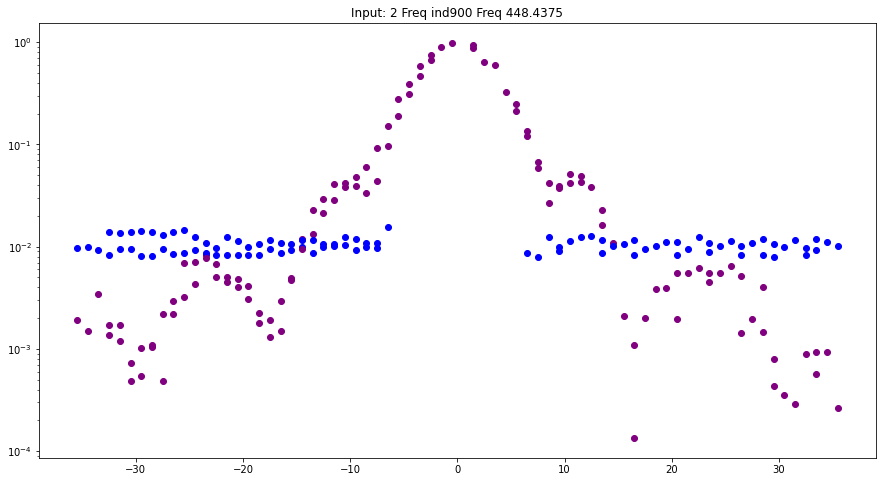

In [10]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar_bgonly.pkl'
with open(bpicklefile, 'rb') as inp:
    bptest = pickle.load(inp)
    
regfile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(regfile, 'rb') as inp:
    fulltest = pickle.load(inp)
    


for i,chind in enumerate(pols[0:2]):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.pcolormesh(bptest.d0_edges_grid[:,:,chind],bptest.d1_edges_grid[:,:,chind],
                   bptest.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

fig = plt.figure(figsize=(15,8)) 
for chind in pols[0:2]:
    plt.semilogy(np.degrees(fulltest.d1_centers_grid[col1,:,chind]),fulltest.V_LC_operation[col1,:,0,chind],'o',
             color='purple',label='Coadd theta :'+str(np.degrees(beamtest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*np.degrees(fulltest.d1_centers_grid[col2,:,chind]),fulltest.V_LC_operation[col2,:,0,chind],'o',
             color='purple',label='Coadd theta :'+str(np.degrees(fulltest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.semilogy(np.degrees(bptest.d1_centers_grid[col1,:,chind]),bptest.V_LC_operation[col1,:,0,chind],'o',
             color='blue',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*np.degrees(bptest.d1_centers_grid[col2,:,chind]),bptest.V_LC_operation[col2,:,0,chind],'o',
             color='blue',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.title('Input: '+str(chind)+ ' Freq ind'+str(find)+' Freq '+str(freqs[find]))
plt.show()

In [ ]:
col1,col2 = get_polar_slice(bptest.d0_centers_grid[:,:,chind],
                          bptest.d1_centers_grid[:,:,chind],0.0)

fig = plt.figure(figsize=(15,8)) 
for chind in pols:
   
    plt.semilogy(np.degrees(bptest.d1_centers_grid[col1,:,chind]),bptest.V_LC_operation[col1,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*np.degrees(bptest.d1_centers_grid[col2,:,chind]),bptest.V_LC_operation[col2,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    #plt.ylim(0.0001,1)
    #plt.xlim(-1*sz,sz)
    #plt.legend(loc='lower center')
    plt.title('Input: '+str(chind)+ ' Freq ind'+str(find)+' Freq '+str(freqs[find]))
plt.show()
    